# How to get and use CellTypist models to annotate data

In [2]:
import scanpy as sc
import pandas as pd
import anndata as ad
from anndata import AnnData
import numpy as np
import collections

from datetime import datetime
import itertools

from typing import Optional

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.sparse import spmatrix

from annotate import annotate 

##if you would like to use the original CellTypist package you will need to install then import it 
##if celltypist is throwing an error with sklearn, install scikit-learn version 1.1.0 & that should fix it
#import celltypist as ct
#from celltypist import models

## Overview

CellTypist is a tool that allows for easy annotation of scRNAseq data. There are a variety of pretrained models avaliable to use to label data. There are some specifications you can make when training your data, such as whether or not to refine labels based on clusters, whether to cell type based on largest classifier scores or to employ multi-label classification, and more. This notebook will walk you through downloading models, prepping data, using CellTypist to annotate, and the checking the quality of the annotations. 

## Models & Data

CellTypist provides a variety of models avaliable to download from https://www.celltypist.org/models. As of 11/03/23, there are 42 models avaliable. All models are for immune cells, sourced from multiple different organisms and tissues, and vary in health and diseases. Models are saved as pickle files.

The models that are trained on the CellTypist data are Immune_All_Low.pkl and Immune_All_High.pkl. They are the same except for the granularity of the data; the Low model has 98 cell types ('low resolution') and the high model has 32 ('high resolution'). You can read more about them and the data they were trained on in original CellTypist paper (https://doi.org/10.1126/science.abl5197). 

The first step is to identify which model will best suit your needs. Things to consider are what the conditions of your data are (healthy, diseased, injured), what organisms and tissues the data came from, and what cell types you expect to be most represented in your data. Once you have chosen which model to use, the next step is to dowload and load the model into your notebook. For more details on downloading and viewing details of a CellTypist model, see sections 1.2-1.4 of the Usage section of the Github README file (https://github.com/Teichlab/celltypist). If you have access to the lilac or calcifer, you will have access to the SAIL models and will not need to download them; you just need the path to them which is `/home/adamsj5/auto_cell_tyiping/celltypist/Full Models/<Dataset Name>_full.pkl` (placeholder). 

In [ ]:
#to download an original CellTypist model 
models.download_models() #all CellTypist Models
models.download_models(model = 'Immune_All_Low.pkl') #download one of them

Once you have your model, the next step is to confirm that your data is in an appropriate form for CellTypist. CellTypist annotate single-cell RNAseq data and can handle either data in a count table (eg `.csv`, `.txt`, `.mtx`, etc) or as AnnData saved in an `.h5ad` file. We recommend data in `.h5ad` files for easiest use. You will need to load in your data to your notebook or the file you are working in. 

In [3]:
adata = ad.read('/data/peer/adamsj5/cell_typing/glasner_fine_annot.h5ad')

Once the data is loaded, there are two quick things to check with your adata. First, you should make sure that the column names are the actual gene names and not the Ensemble IDs since CellTypist models are usually trained on those names. 

In [4]:
adata.var_names
#adata.var = adata.var.set_index('feature_name') #to rename to gene names based on a column in .var

Index(['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A3GALT2', 'A4GALT', 'A4GNT', 'AAAS',
       'AACS', 'AADAC',
       ...
       'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', name='gene_name', length=25441)

The second is to see if `X_umap` is included in `.obsm` of your adata. This will be needed for the annotation QC later on. If it isn't, use `sc.tl.umap()`.

In [5]:
adata

AnnData object with n_obs × n_vars = 82991 × 25441
    obs: 'histology', 'Procedure_Type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'Phenograph_cluster', 'sample_number', 'hta_id', 'Gender', 'Ethnicity', 'Race', 'Smoking Status', 'Pack Years', 'Stage at Dx', 'Tissue Type', 'ProcedureType', 'Treatment Status', 'Tissue Site', 'tissue', 'hta_donor_id', 'organism', 'disease', 'development_stage', 'suspension_type', 'assay', 'cell_lineage', 'finer_cell_types', 'orig_cell_types'
    var: 'ribo', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable'
    uns: 'Phenograph_cluster_colors', 'dendrogram_Phenograph_cluster', 'neighbors', 'pca', 'sample_name_colors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

You also need to make sure that it is in an approriate format. If you are using AnnData, CellTypist expects the RNAseq count data in `adata.X` with cells as the rows and genes as the columns. The original CellTypist package expects either data normalized to 10,000 counts per cell and then log normalized or that the raw counts are present in `adata.raw`. While the original CellTypist annotate() function would throw an error when these conditions were not met, the SAIL annotation function overrides this and just prints a warning message instead. Because of this, please make sure that your data is normalized how you would like before you begin cell type annotation. You can also imput raw data that will then be normalized for you. 

In [6]:
#one way to see how many counts per cell your data is normalized to, assuming it was log normalized after
np.expm1(adata.X[0]).sum() #the number this produces should be very close to the value you normalized to (just looking at the first cell)

9923.356

## Annotation

Now, you should be ready to annotate you data. There are some arguments for the annotate() function that can have an effect on the output: 
1. `filename`: Path to the file to be annotate or a AnnData object already loaded into memory.
2. `model`: Path to the model file, model name (if a CellTypist model that has been downloaded), or a :class:~celltypist.models.Model object.
3. `transpose_input`: Whether to transpose the input matrix (aka if the data is in a genexcell format).
4. `gene_file`: *ignore if not `.mtx`* Path to file that contains gene names that correspond to the columns of the input data 
5. `cell_file`: *ignore if not `.mtx`* Path to file that contains cell names that correspond to rows
6. `mode`: The way cell prediction is preformed ('best match' -default or 'prob match')
7. `p_thres`: *ignore if `mode = 'best match'`* Probability threshold for the multi-label classification
8. `majority_voting`: Whether to provide a second set annotations based on clusters formed by overclustering 
9. `over_clustering`: *ignore if `majority_voting = False`* A plain file, python list, tuple, numpy array, pandas series or index, or label of AnnData .obs column. If blank it will use a over-clustering approach based on the size of the data. 
10. `min_prop`: The minimum proportion of cells in a cluster that need to support the dominant cell type for all cells to be assigned that cell type

For first passes, we recommend `annotate(filename = <FILENAME>, model = <MODEL>)` for basic, default parameters. If you are unhappy with the results, you can adjust the parameters. It should not take longer than 30 minutes to annotate a dataset smaller than 1 million cells and can be quite quick for small datasets. 

In [12]:
predictions = annotate(adata, model = "/home/adamsj5/auto_cell_typing/celltypist/Final Models/g_full.pkl") #replace with path to the model, or model object

⚠️ Warning: invalid expression matrix, expect all genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 82991 cells and 25441 genes
🔗 Matching reference genes in the model
🧬 2855 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


The output of this function is an ~celltypist.classifier.AnnotationResult object which is not particularly easy to work with. For a more workable end result, convert this output into AnnData. This AnnData object will have some important information in `.obs`: a column `predicted_labels` that contains the cell type annotation without majority voting, a column `conf_score` that contains the confidence score for each cell's `predicted_labels` label, and (if you used majority voting) a column `majority_voting` that contains the cell type labels curated through clustering. There should be an easy way to get the confidence score of majority voting instead of predicted labels, however I have found that it is not reliable. It is possible to get it manually. 

In [13]:
adata_preds = predictions.to_adata()

## QC

It is important to check the annotations that CellTypist outputs before moving forward with your analysis. Assuming your dataset does not have groundtruth cell type annotations, there are a few things that you can check.

First, you can see how many cells of each type there are in your dataset. If a large proportion of cells falls into one label (and you were not expecting that), something may have gone wrong. Also check to see if any major cell type that you expected to see is missing (given that it was one of the labels in the model).  

In [17]:
collections.Counter(adata_preds.obs['predicted_labels'])

Counter({'T/NK': 36967,
         'Epithelial': 21974,
         'B cell': 8101,
         'Macrophage': 2376,
         'Smooth_muscle': 2264,
         'Macrophage_Alveolar': 2153,
         'Mast': 1650,
         'Myeloid': 1374,
         'alveolar_lung_fibroblast': 1128,
         'cDC2': 820,
         'neutrophil': 809,
         'pericyte': 782,
         'cMonocyte': 734,
         'LRRC15_myofibroblast': 584,
         'ncMonocyte': 317,
         'DC_Langerhans': 259,
         'cycling_macrophage': 233,
         'pDC': 170,
         'adventitial_fibroblast': 114,
         'cDC1': 89,
         'DC_Mature': 89,
         'Neutrophil': 4})

Another way to look at the annotations is to make a UMAP coloured by cell type label. You will need `X_umap` in the AnnData's `.obsm` for this. The UMAP will again let you see if a concerning proportion of the cells are labeled with one cell type. It will also let you see if the annotations make sense with the clusters, in a broad sense. If you are colouring the UMAP using `predicted_labels` column, the colouring will likely not match perfectly with the clusters as they were not taken into consideration during the annotation step. However, if there are two clusters very far apart from each other that have the same label, this is a red flag and is worth investigating further. This method will become slightly less effective with models that have very granular cell types (>40 cell types). 

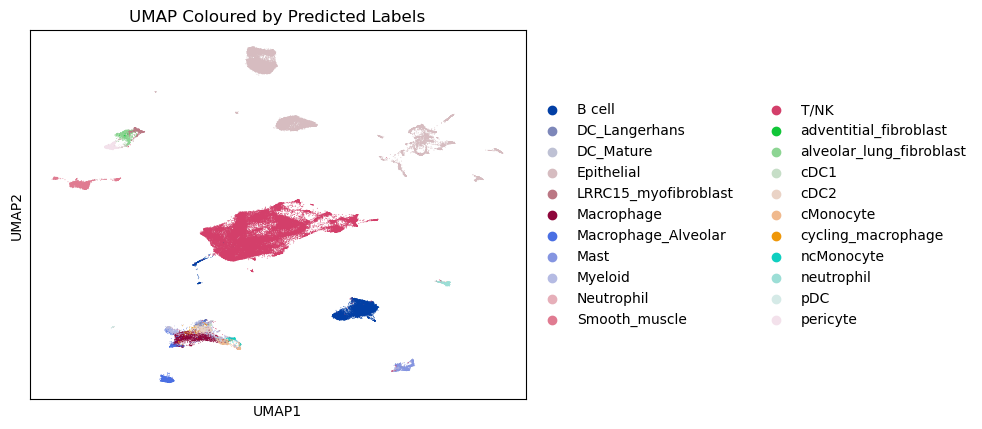

In [18]:
sc.pl.umap(adata_preds, color = ['predicted_labels'], title = "UMAP Coloured by Predicted Labels")

Our last QC recommendation is to look at a UMAP coloured by the confidence score as well as the distribution of confidence scores. There will likely be very few cells with 0.1 < confidence score < 0.9, and most will fall to either extreme. It is normal for there to be some proportion of cells with low confidence scores, meaning the model was unsure in its annotation. However, if this number is close to equal to the number of cells with high confidence scores, something may have gone wrong. Also, by looking at the UMAP, you can see if there are certain clusters or cell types that the model had a harder time labelling. By pairing it with the UMAP coloured by cell types, you can look at the relationship between confidence score and your own confidence in the labels. For example, it would be alarming if you identified a cluster whose labels seemed incorrect due to prior knowledge, yet the confidence score for that cluster was very high.   

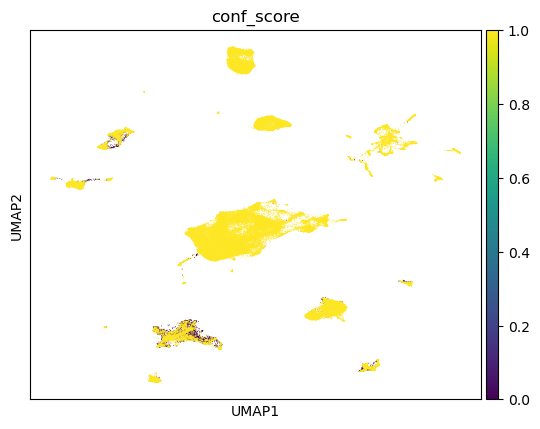

(-0.002, 0.25]     4349
(0.25, 0.5]          40
(0.5, 0.75]          47
(0.75, 1.0]       78555
Name: count, dtype: int64


In [19]:
sc.pl.umap(adata_preds, color = ['conf_score'])
print(adata_preds.obs['conf_score'].value_counts(bins=4, sort=False)) #how many cells in each quarter of the conf scores

If at any of these steps you identified an issues with the annotation, the primary course of action would be to try a different model. The labels the model produces is very dependant on the cell polutation and conditions of the data it was trained on and, if these do not match with your data, the model could mislabel your cells. Unfortunatley a major limitation of CellTypist is the models that have been produced; in order to be able to accurately label cells, CellTypist needs to have been trained on a manually labelled dataset that matches your cell population well enough. If you have an annotated dataset that you would like to use to train a model, see 'How To Train a CellTypist Model.ipynb'.

No cell type annotation done by a CellTypist model (or any automatic cell typing model) will be completely accurate and there is bound to be some cells that are incorrectly labeled. It is very important that you judge the quality of the annotations yourself and often CellTypist should just be used as a starting point for labelling data. Incorperating your own expertise into the cell types will only strengthen the quality of your downstream analysis. 